# Introduction to Spatial Omics with 10X Xenium and Visium


## The breast cancer dataset

## Setup


### Download data


### Required packages

In [1]:
import pandas
import pathlib
import numpy
import scanpy
import matplotlib
import seaborn
import scipy
import sklearn # scikit-learn is imported as sklearn
import igraph as igraph_lib # python-igraph is often imported as igraph
import leidenalg
import squidpy
import zarr
import numcodecs
import anndata 
import h5py


print("--- Installed Package Versions ---")
print(f"pandas:          {pandas.__version__}")
print(f"pathlib:         Standard Library (no version attribute)")
print(f"numpy:           {numpy.__version__}")
print(f"scanpy:          {scanpy.__version__}")
print(f"matplotlib:      {matplotlib.__version__}")
print(f"seaborn:         {seaborn.__version__}")
print(f"scipy:           {scipy.__version__}")
print(f"scikit-learn:    {sklearn.__version__}")
print(f"python-igraph:   {igraph_lib.__version__}")
print(f"leidenalg:       {leidenalg.__version__}")
print(f"squidpy:         {squidpy.__version__}")
print(f"zarr:            {zarr.__version__}")
print(f"numcodecs:       {numcodecs.__version__}")
print(f"anndata:         {anndata.__version__}")
print(f"h5py:            {h5py.__version__}")
print("----------------------------------")

/opt/envs/01-spatial/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/envs/01-spatial/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/opt/envs/01-spatial/lib/python3.11/site-packages/squidpy/gr/_utils.py:23: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  CAN_USE_SPARSE_ARRAY = Version(anndata.__version__) >= Version("0.11.0rc1")


--- Installed Package Versions ---
pandas:          2.3.3
pathlib:         Standard Library (no version attribute)
numpy:           2.3.4
scanpy:          1.11.5
matplotlib:      3.10.7
seaborn:         0.13.2
scipy:           1.16.3
scikit-learn:    1.7.2
python-igraph:   1.0.0
leidenalg:       0.11.0
squidpy:         1.6.5
zarr:            2.18.7
numcodecs:       0.15.1
anndata:         0.12.5
h5py:            3.15.1
----------------------------------


/opt/envs/01-spatial/lib/python3.11/site-packages/anndata/__init__.py:70: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/tmp/ipykernel_1229/3858032575.py:22: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print(f"scanpy:          {scanpy.__version__}")
/tmp/ipykernel_1229/3858032575.py:32: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  print(f"anndata:         {anndata.__version__}")


In [2]:
import pandas as pd
from pathlib import Path
import os
from collections import namedtuple, Counter
import numpy as np
import scanpy as sc
# import squidpy as sq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import KDTree
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Dict, Tuple
FIGSIZE=(5,5)
rcParams['figure.figsize']=FIGSIZE
from typing import Tuple, Union, List, Optional, Dict

import anndata as ad
import squidpy as sq

%load_ext autoreload
%autoreload 2

from sklearn.neighbors import KDTree
import numpy as np
from scipy.sparse import lil_matrix

import warnings
warnings.filterwarnings("ignore")

datadir = "../../datasets/Hands_on_1_Spatial_Data/"

### Required functions

In [34]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score, f1_score
def compute_clustering_scores(
    adata: sc.AnnData, cell_type_column: str = "celltype_major", use_pca: bool = True
) -> Tuple[float, float]:
    """Compute the Calinski-Harabasz and Silhouette scores for an AnnData object."""
    if cell_type_column not in adata.obs:
        raise ValueError(f"Column '{cell_type_column}' must be present in adata.obs.")

    # Randomly sample a subset for efficiency (e.g., 10,000 cells)
    n_cells = min(adata.n_obs, 10000)  # Limit to 10k cells
    cell_indices = np.random.choice(adata.n_obs, n_cells, replace=False)

    # Select features
    features = adata.obsm["X_pca"] if use_pca else adata.X
    features = features[cell_indices, :]
    labels = adata[cell_indices, :].obs[cell_type_column].values

    # Compute scores
    ch_score = calinski_harabasz_score(features, labels)
    sh_score = silhouette_score(features, labels)
    return ch_score, sh_score





def plot_embedding(
    adata: sc.AnnData,
    features: Union[str, List[str]],
    basis: str = 'X_umap',
    palette: str = "tab20",
    cmap: str = "plasma",
    titles: Union[str, List[str]] = None,
    ncols: int = 5,
    dim: int = 5,
    layer: str = "imputed",
    dim_label = "UMAP",
    ax = None,
    fs: int = 12,
    lw: float = 1.5,
    arrow_len: float = 0.2,
    draw_arrows=False,
    rasterized=False,
    legend=False,
    **kwargs,
):
    iterify = lambda x: x if isinstance(x, Iterable) and not isinstance(x, str) else [x]
    features = iterify(features)
    titles = iterify(titles)
    if not ax:
        nrows = math.ceil(len(features))
        fig, axes = plt.subplots(
            nrows, ncols,
            figsize=(dim*ncols,dim*nrows),
        )
        fig.tight_layout(pad=dim*0.75)
        axes = axes.flat if isinstance(axes, Iterable) else [axes]
    else:
        assert (len(features)==1) and (len(titles)==1)
        fig = ax.get_figure()
        axes = [ax]
    if legend:
        legend_loc='right margin'
    else:
        legend_loc=None
    for ax, feature, title in itertools.zip_longest(axes, features, titles):
        if not title: title = feature
        if feature:
            sc.pl.embedding(
                adata,
                basis=basis,
                color=feature,
                ax=ax,
                show=False,
                palette=palette, cmap=cmap,
                layer=layer,
                legend_loc=legend_loc,
                **kwargs,
            )
            if rasterized:
                ax.get_children()[0].set_rasterized(True)
            format_ax(
                fig, ax, style="umap",
                title=title, dim_label=dim_label, fs=fs,
                arrow_len=arrow_len, lw=lw, draw_arrows=draw_arrows,
            )
        else:
            ax.set_visible(False)
    return fig



def find_markers(
    adata: ad.AnnData,
    cell_type_column: str,
    pos_percentile: float = 5,
    neg_percentile: float = 10,
    percentage: float = 50,
) -> Dict[str, Dict[str, List[str]]]:
    """Identify positive and negative markers for each cell type based on gene expression and filter by expression percentage.

    Args:
    - adata: AnnData
        Annotated data object containing gene expression data.
    - cell_type_column: str
        Column name in `adata.obs` that specifies cell types.
    - pos_percentile: float, default=5
        Percentile threshold to determine top x% expressed genes.
    - neg_percentile: float, default=10
        Percentile threshold to determine top x% lowly expressed genes.
    - percentage: float, default=50
        Minimum percentage of cells expressing the marker within a cell type for it to be considered.

    Returns:
    - markers: dict
        Dictionary where keys are cell types and values are dictionaries containing:
            'positive': list of top x% highly expressed genes
            'negative': list of top x% lowly expressed genes.
    """
    markers = {}
    sc.tl.rank_genes_groups(adata, groupby=cell_type_column)
    genes = adata.var_names
    for cell_type in adata.obs[cell_type_column].unique():
        subset = adata[adata.obs[cell_type_column] == cell_type]
        mean_expression = np.asarray(subset.X.mean(axis=0)).flatten()
        cutoff_high = np.percentile(mean_expression, 100 - pos_percentile)
        cutoff_low = np.percentile(mean_expression, neg_percentile)
        pos_indices = np.where(mean_expression >= cutoff_high)[0]
        neg_indices = np.where(mean_expression <= cutoff_low)[0]
        expr_frac = np.asarray((subset.X[:, pos_indices] > 0).mean(axis=0)).flatten()
        valid_pos_indices = pos_indices[expr_frac >= (percentage / 100)]
        positive_markers = genes[valid_pos_indices]
        negative_markers = genes[neg_indices]
        markers[cell_type] = {"positive": list(positive_markers), "negative": list(negative_markers)}
    return markers


def find_mutually_exclusive_genes(
    adata: ad.AnnData, markers: Dict[str, Dict[str, List[str]]], cell_type_column: str
) -> List[Tuple[str, str]]:
    """Identify mutually exclusive genes based on expression criteria.

    Args:
    - adata: AnnData
        Annotated data object containing gene expression data.
    - markers: dict
        Dictionary where keys are cell types and values are dictionaries containing:
            'positive': list of top x% highly expressed genes
            'negative': list of top x% lowly expressed genes.
    - cell_type_column: str
        Column name in `adata.obs` that specifies cell types.

    Returns:
    - exclusive_pairs: list
        List of mutually exclusive gene pairs.
    """
    exclusive_genes = {}
    all_exclusive = []
    gene_expression = adata.to_df()
    for cell_type, marker_sets in markers.items():
        positive_markers = marker_sets["positive"]
        exclusive_genes[cell_type] = []
        for gene in positive_markers:
            gene_expr = adata[:, gene].X
            cell_type_mask = adata.obs[cell_type_column] == cell_type
            non_cell_type_mask = ~cell_type_mask
            if (gene_expr[cell_type_mask] > 0).mean() > 0.2 and (gene_expr[non_cell_type_mask] > 0).mean() < 0.05:
                exclusive_genes[cell_type].append(gene)
                all_exclusive.append(gene)
    unique_genes = list({gene for i in exclusive_genes.keys() for gene in exclusive_genes[i] if gene in all_exclusive})
    filtered_exclusive_genes = {
        i: [gene for gene in exclusive_genes[i] if gene in unique_genes] for i in exclusive_genes.keys()
    }
    mutually_exclusive_gene_pairs = [
        (gene1, gene2)
        for key1, key2 in combinations(filtered_exclusive_genes.keys(), 2)
        for gene1 in filtered_exclusive_genes[key1]
        for gene2 in filtered_exclusive_genes[key2]
    ]
    return mutually_exclusive_gene_pairs


def compute_MECR(adata: ad.AnnData, gene_pairs: List[Tuple[str, str]]) -> Dict[Tuple[str, str], float]:
    """Compute the Mutually Exclusive Co-expression Rate (MECR) for each gene pair in an AnnData object.

    Args:
    - adata: AnnData
        Annotated data object containing gene expression data.
    - gene_pairs: List[Tuple[str, str]]
        List of tuples representing gene pairs to evaluate.

    Returns:
    - mecr_dict: Dict[Tuple[str, str], float]
        Dictionary where keys are gene pairs (tuples) and values are MECR values.
    """
    mecr_dict = {}
    gene_expression = adata.to_df()
    for gene1, gene2 in gene_pairs:
        expr_gene1 = gene_expression[gene1] > 0
        expr_gene2 = gene_expression[gene2] > 0
        both_expressed = (expr_gene1 & expr_gene2).mean()
        at_least_one_expressed = (expr_gene1 | expr_gene2).mean()
        mecr = both_expressed / at_least_one_expressed if at_least_one_expressed > 0 else 0
        mecr_dict[(gene1, gene2)] = mecr
    return mecr_dict


def compute_quantized_mecr_area(
    adata: sc.AnnData, gene_pairs: List[Tuple[str, str]], quantiles: int = 10
) -> pd.DataFrame:
    """Compute the average MECR, variance of MECR, and average cell area for quantiles of cell areas.

    Args:
    - adata: AnnData
        Annotated data object containing gene expression data.
    - gene_pairs: List[Tuple[str, str]]
        List of tuples representing gene pairs to evaluate.
    - quantiles: int, default=10
        Number of quantiles to divide the data into.

    Returns:
    - quantized_data: pd.DataFrame
        DataFrame containing quantile information, average MECR, variance of MECR, average area, and number of cells.
    """
    adata.obs["quantile"] = pd.qcut(adata.obs["cell_area"], quantiles, labels=False)
    quantized_data = []
    for quantile in range(quantiles):
        cells_in_quantile = adata.obs["quantile"] == quantile
        mecr = compute_MECR(adata[cells_in_quantile, :], gene_pairs)
        average_mecr = np.mean([i for i in mecr.values()])
        variance_mecr = np.var([i for i in mecr.values()])
        average_area = adata.obs.loc[cells_in_quantile, "cell_area"].mean()
        quantized_data.append(
            {
                "quantile": quantile / quantiles,
                "average_mecr": average_mecr,
                "variance_mecr": variance_mecr,
                "average_area": average_area,
                "num_cells": cells_in_quantile.sum(),
            }
        )
    return pd.DataFrame(quantized_data)


def compute_quantized_mecr_counts(
    adata: sc.AnnData, gene_pairs: List[Tuple[str, str]], quantiles: int = 10
) -> pd.DataFrame:
    """Compute the average MECR, variance of MECR, and average transcript counts for quantiles of transcript counts.

    Args:
    - adata: AnnData
        Annotated data object containing gene expression data.
    - gene_pairs: List[Tuple[str, str]]
        List of tuples representing gene pairs to evaluate.
    - quantiles: int, default=10
        Number of quantiles to divide the data into.

    Returns:
    - quantized_data: pd.DataFrame
        DataFrame containing quantile information, average MECR, variance of MECR, average counts, and number of cells.
    """
    adata.obs["quantile"] = pd.qcut(adata.obs["transcripts"], quantiles, labels=False)
    quantized_data = []
    for quantile in range(quantiles):
        print(quantile)
        cells_in_quantile = adata.obs["quantile"] == quantile
        mecr = compute_MECR(adata[cells_in_quantile, :], gene_pairs)
        average_mecr = np.mean([i for i in mecr.values()])
        variance_mecr = np.var([i for i in mecr.values()])
        average_counts = adata.obs.loc[cells_in_quantile, "transcripts"].mean()
        quantized_data.append(
            {
                "quantile": quantile / quantiles,
                "average_mecr": average_mecr,
                "variance_mecr": variance_mecr,
                "average_counts": average_counts,
                "num_cells": cells_in_quantile.sum(),
            }
        )
    return pd.DataFrame(quantized_data)




def calculate_sensitivity(
    adata: ad.AnnData, purified_markers: Dict[str, Dict[str, List[str]]], max_cells_per_type: int = 1000
) -> Dict[str, List[float]]:
    """Calculate the sensitivity of purified markers for each cell type based on non-negative markers.
    Args:
    - adata: AnnData
        Annotated data object containing gene expression data.
    - purified_markers: dict
        Dictionary where keys are cell types, and values are dictionaries with keys
        "positive" (genes to be expressed) and "negative" (genes not to be expressed).
    - max_cells_per_type: int, default=1000
        Maximum number of cells to consider per cell type.

    Returns:
    - sensitivity_results: dict
        Dictionary with cell types as keys and lists of sensitivity values for each cell.
    """
    sensitivity_results = {cell_type: [] for cell_type in purified_markers.keys()}

    for cell_type, markers in purified_markers.items():
        positive_markers = markers["positive"]

        subset = adata[adata.obs["celltype_major"] == cell_type]

        if subset.n_obs > max_cells_per_type:
            cell_indices = np.random.choice(subset.n_obs, max_cells_per_type, replace=False)
            subset = subset[cell_indices]

        for cell_counts in subset.X:
            # Total counts for all positive and positive markers
            positive_indices = subset.var_names.get_indexer(positive_markers)
            total_counts = cell_counts.sum()
            positive_counts = cell_counts[positive_indices].sum() if positive_markers else 0
            # Sensitivity: Proportion of counts from non-positive markers
            sensitivity = positive_counts / total_counts if total_counts > 0 else 0
            sensitivity_results[cell_type].append(sensitivity)

    return sensitivity_results



def plot_quantized_mecr_counts(
    quantized_mecr_counts: Dict[str, pd.DataFrame], palette: Dict[str, str]
) -> None:
    """Plot the quantized MECR values against transcript counts for each segmentation method,
    with point size proportional to the variance of MECR.

    Args:
        quantized_mecr_counts (Dict[str, pd.DataFrame]): Dictionary of quantized MECR count data for each segmentation method.
        palette (Dict[str, str]): Dictionary mapping segmentation method names to color codes.
    """
    # Apply Arial font
    plt.rcParams['font.family'] = 'Arial'

    # Create the plot
    plt.figure(figsize=(3, 3))  # Slim plot
    for method, df in quantized_mecr_counts.items():
        # Plot lines
        plt.plot(
            df["average_counts"],
            df["average_mecr"],
            marker="o",
            linestyle="-",
            color=palette.get(method, "#333333"),
            label=method,
            markersize=0,  # No markers, only lines
        )
        # Scatter points with size proportional to variance
        plt.scatter(
            df["average_counts"],
            df["average_mecr"],
            s=df["variance_mecr"] * 8 * 1e4,  # Size of points based on variance
            color=palette.get(method, "#333333"),
            alpha=1,  # Transparency for overlapping points
            edgecolor="w",  # White edge for better visibility
            linewidth=0.5,  # Thin edge lines
        )

    # Styling
    plt.title("", fontsize=12, pad=10)
    plt.xlabel("Average Transcript Counts", fontsize=10)
    plt.ylabel("Quantized MECR by Transcript Count", fontsize=10)

    # Set y-axis ticks to 2-3 values with .2f format
    ymin, ymax = plt.ylim()
    y_ticks = [ymin, (ymin + ymax) / 3, (ymin + ymax) / 1.5, ymax]
    plt.yticks(y_ticks, [f"{tick:.2f}" for tick in y_ticks], fontsize=8)

    # Set x-axis ticks for better readability
    plt.xticks(fontsize=8)

    # Remove horizontal grid and minimize clutter
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)  # Emphasize y-axis
    ax.spines['bottom'].set_linewidth(1.5)  # Emphasize x-axis

    # plt.grid(False)
    # sns.despine(left=True, bottom=True)

    # Adjust legend placement outside the plot
    plt.legend(
        title="",
        bbox_to_anchor=(1.05, 1),
        loc=None,
        fontsize=12,
        frameon=False
    )
    plt.gca().add_artist(plt.legend(
        title="",
        loc=None,
        fontsize=12,
        frameon=False,
    ))
    plt.tight_layout()

    # Display the plot
    plt.show()


from sklearn.metrics import calinski_harabasz_score, silhouette_score, f1_score
def compute_clustering_scores(
    adata: sc.AnnData, cell_type_column: str = "celltype_major", use_pca: bool = True
) -> Tuple[float, float]:
    """Compute the Calinski-Harabasz and Silhouette scores for an AnnData object."""
    if cell_type_column not in adata.obs:
        raise ValueError(f"Column '{cell_type_column}' must be present in adata.obs.")

    # Randomly sample a subset for efficiency (e.g., 10,000 cells)
    n_cells = min(adata.n_obs, 10000)  # Limit to 10k cells
    cell_indices = np.random.choice(adata.n_obs, n_cells, replace=False)

    # Select features
    features = adata.obsm["X_pca"] if use_pca else adata.X
    features = features[cell_indices, :]
    labels = adata[cell_indices, :].obs[cell_type_column].values

    # Compute scores
    ch_score = calinski_harabasz_score(features, labels)
    sh_score = silhouette_score(features, labels)
    return ch_score, sh_score




def preprocess_adata(
    reference_adata: ad.AnnData, query_adata: ad.AnnData, transfer_column: str, min_counts: int = 5, max_counts: int = 500
) -> ad.AnnData:
    """Annotate query AnnData object using a scRNA-seq reference atlas.

    Args:
    - reference_adata: ad.AnnData
        Reference AnnData object containing the scRNA-seq atlas data.
    - query_adata: ad.AnnData
        Query AnnData object containing the data to be annotated.
    - transfer_column: str
        The name of the column in the reference atlas's `obs` to transfer to the query dataset.

    Returns:
    - query_adata: ad.AnnData
        Annotated query AnnData object with transferred labels and UMAP coordinates from the reference.
    """
    common_genes = list(set(reference_adata.var_names) & set(query_adata.var_names))
    reference_adata = reference_adata[:, common_genes]
    query_adata = query_adata[:, common_genes]
    # min_counts = np.percentile(query_adata.obs.transcripts.values, 5)
    # print(min_counts)
    # max_counts = np.percentile(query_adata.obs.transcripts.values,99)
    # print(max_counts)
    sc.pp.filter_cells(query_adata, min_counts=min_counts)
    sc.pp.filter_cells(query_adata, max_counts=max_counts)
    query_adata.layers["raw"] = query_adata.raw.X if query_adata.raw else query_adata.X
    # query_adata.var["raw_counts"] = query_adata.layers["raw"].sum(axis=0)
    sc.pp.normalize_total(query_adata, target_sum=1e4)
    sc.pp.log1p(query_adata)
    sc.tl.ingest(query_adata, reference_adata, obs=transfer_column, embedding_method='umap')
    query_adata.obsm["X_umap_ref"] = query_adata.obsm["X_umap"]
    sc.pp.pca(query_adata)
    sc.pp.neighbors(query_adata)
    sc.tl.umap(query_adata)
    return query_adata


def knn_adjacency_matrix(data_matrix, k):
    # Construct a KDTree from the data matrix
    tree = KDTree(data_matrix)

    # Query the KDTree to find k nearest neighbors for each point
    distances, indices = tree.query(data_matrix, k+1)  # k+1 because the nearest neighbor is the point itself

    # Initialize a sparse matrix to hold the adjacency matrix
    n = len(data_matrix)
    adjacency_matrix = lil_matrix((n, n), dtype=int)

    # Populate the adjacency matrix
    for i in range(n):
        for j in indices[i, 1:]:  # Exclude the first neighbor (itself)
            adjacency_matrix[i, j] = 1
            adjacency_matrix[j, i] = 1  # Assuming undirected graph

    return adjacency_matrix

### Static values

In [3]:
major_colors = {
    "Malignant": "#8E1600",      # Deep muted red
    "T": "#1F77B4",             # Muted blue
    "Plasma": "#76A7CB",        # Soft blue
    "Myeloid": "#4C72B0",       # Balanced deep blue
    "Fibroblast": "#A1B56C",    # Muted green
    "B": "#64B5CD",             # Soft cyan
    "Unknown": "#999999",       # Neutral gray
    "Endothelial": "#5B8A72",   # Earthy green
    "myofibroblast": "#C4A484", # Muted brownish beige
    "Pericyte": "#E3C16F",      # Warm sand
    "NK": "#6B4C9A"             # Muted violet
}

xenium_tag = 'Xenium_V1_Human_Colon_Cancer_P1_CRC_Add_on_FFPE_outs'

mtx_f = os.path.join(datadir, xenium_tag, 'cell_feature_matrix.h5')
obs_f = os.path.join(datadir, xenium_tag, 'cells.csv.gz')
sc_f  = os.path.join(datadir, 'CRC_UNB_10X_GSE132465.h5ad')


## Spatial transcriptomics from the lens of single cells

### Read in the data

Note that on both datasets, `sc.pp.pca`, `sc.pp.neighbors`, and `sc.tl.umap` was already applied. Further, both datasets were subsampled and prepared for UMAP plotting: 
```python
# Xenium data
xenium_data     = sc.read_10x_h5(mtx_f)
obs             = pd.read_csv(obs_f, compression='gzip')
xenium_data.obs = obs
sc.pp.subsample(xenium_data, 0.2) #subset the xenium to smaller set

# scRNAseq data
scRNAseq_data   = sc.read(os.path.join(datadir, 'CRC_UNB_10X_GSE132465.h5ad'))
sc.pp.subsample(scRNAseq_data, 0.2) #subset the xenium to smaller set

sc.pp.pca(scRNAseq_data)
sc.pp.neighbors(scRNAseq_data)
sc.tl.umap(scRNAseq_data)

sc.pp.pca(xenium_data)
sc.pp.neighbors(xenium_data)
sc.tl.leiden(xenium_data, 0.5)
sc.tl.umap(xenium_data)

# Subset to same genes
genes           = list(set(xenium_data.var_names) & set(scRNAseq_data.var_names))
xenium_data     = xenium_data[:, genes]
scRNAseq_data   = scRNAseq_data[:, genes]
```

In [4]:
xenium_data = sc.read_h5ad(os.path.join(datadir, 'xenium_data.h5ad'))
scRNAseq_data = sc.read_h5ad(os.path.join(datadir, 'scRNAseq_data.h5ad'))

In [5]:
# Subset to same genes
genes           = list(set(xenium_data.var_names) & set(scRNAseq_data.var_names))
xenium_data     = xenium_data[:, genes]
scRNAseq_data   = scRNAseq_data[:, genes]

In [6]:
print(scRNAseq_data)
print(xenium_data)

View of AnnData object with n_obs × n_vars = 10650 × 412
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'tissue', 'Sample', 'annotation_authors', 'Disease_subtype', 'percent.mt', 'seurat_clusters', 'annotation_CHETAH', 'copykat.pred', 'cell_ontology', 'cell_ontology_id', 'annotation_major', 'annotation_immune', 'annotation_minor'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 61552 × 412
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
   

In [7]:
xenium_data.obsm['spatial'] = xenium_data.obs[['x_centroid', 'y_centroid']].values



### Good old UMAPs!

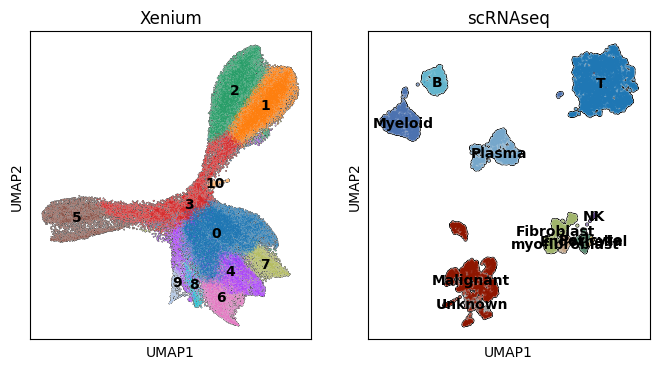

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.umap(
        xenium_data,
        color='leiden',
        show=False,
        ax=axs[0],
        add_outline=True,
        legend_loc="on data",
        # palette=major_colors,
        title='Xenium',
    )
sc.pl.umap(
        scRNAseq_data,
        color='annotation_major',
        show=False,
        ax = axs[1],
        legend_loc="on data",
        add_outline=True,
        palette=major_colors,
        title='scRNAseq',
    )
plt.show()

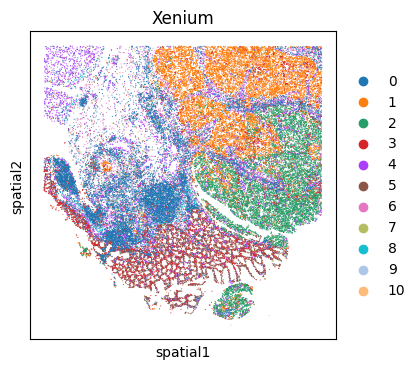

In [9]:
from matplotlib.pyplot import rc_context
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.spatial(
            xenium_data,
            color=[
                'leiden'
            ],
            # library_id="spatial",
            # show=False,
            # ax = axs[1],
            ncols=2,
            spot_size=25,
            title='Xenium',
            # save='leiden_space.pdf'
        )



## Preprocessing (as in scRNAseq!)

### 1. Quality control and Filtering




In [10]:
sc.pp.calculate_qc_metrics(xenium_data, percent_top=(10, 20, 50, 150), inplace=True)
#List of ranks (where genes are ranked by expression) at which the cumulative proportion of expression will be reported as a percentage.
#This can be used to assess library complexity.

#e.g. percent_top=[50] : for each cell cumulative expression of 50 highest expressed genes from total expression is calculated


In [11]:
cprobes = (
    xenium_data.obs["control_probe_counts"].sum() / xenium_data.obs["total_counts"].sum() * 100
) # pct of control probes of all probes -> used to control for
cwords = (
    xenium_data.obs["control_codeword_counts"].sum() / xenium_data.obs["total_counts"].sum() * 100
) # pct of control codewords

<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

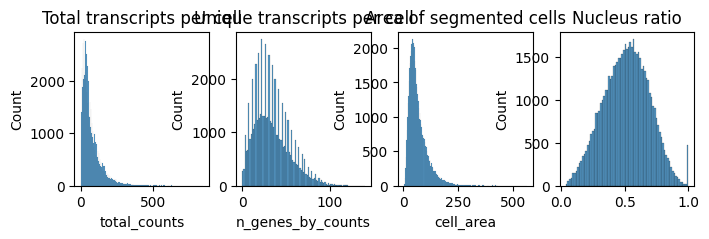

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(8, 2))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    xenium_data.obs["total_counts"],
    kde=False,
    ax=axs[0],
) #plot histogram of total number of transripts per cell

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    xenium_data.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
) #plot histogram of unique number of transripts per cell


axs[2].set_title("Area of segmented cells")
sns.histplot(
    xenium_data.obs["cell_area"],
    kde=False,
    ax=axs[2],
) #plot histogram of cell sizez/areas

axs[3].set_title("Nucleus ratio")
sns.histplot(
    xenium_data.obs["nucleus_area"] / xenium_data.obs["cell_area"],
    kde=False,
    ax=axs[3],
) #plot histogram of ratios of nuclei-to-cell sizes (-areas)




In [13]:
sc.pp.filter_cells(xenium_data, min_counts = 5)
sc.pp.filter_genes(xenium_data, min_cells = 100)
#filter out cells with less than 5 transcripts detected and genes that are detected in less than 100 cells

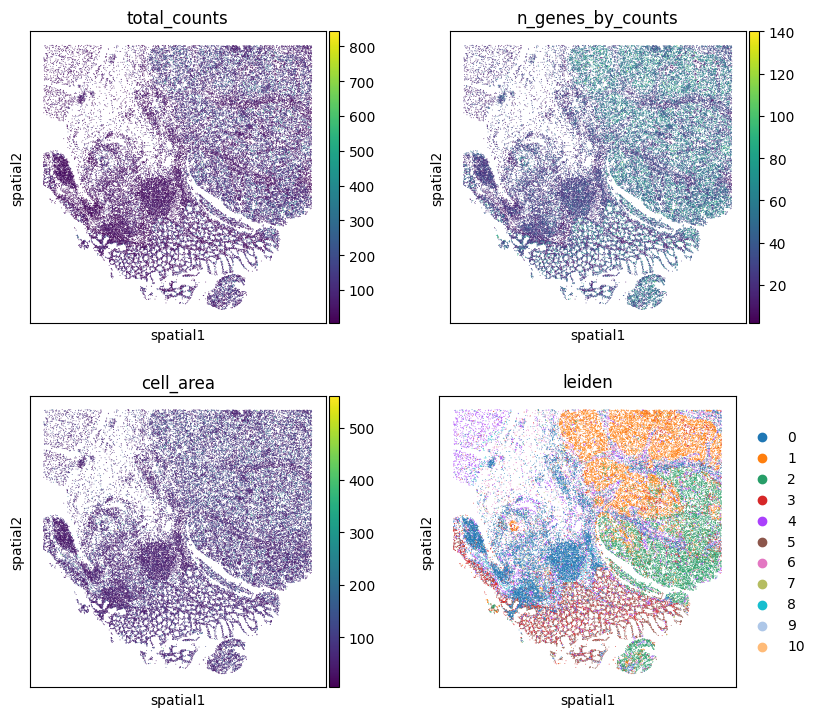

In [14]:
from matplotlib.pyplot import rc_context
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.spatial(
            xenium_data,
            color=[
                "total_counts",
                "n_genes_by_counts",
                "cell_area",
                'leiden'
            ],
            # library_id="spatial",
            # show=False,
            # ax = axs[1],
            ncols=2,
            spot_size=20,
            # title='Xenium',
            # save='metrics.pdf'
        )
    #overlay 2D sample-maps with:
      #total counts of transcripts per cell
      #number of unique transcripts per cell

### 2. Normalization and dimension reduction

The `xenium_data` has log-normalized data in `adata.X` and raw counts in `adata.layers["counts"]`
```python 
xenium_data.layers["counts"] = xenium_data.X.copy() # backup of raw counts
sc.pp.normalize_total(xenium_data, inplace=True) # normalizes each cells total gene count to the same total count -> highly expressed cells should not be overrepresented
sc.pp.log1p(xenium_data) # Applies a log(1 + x) transformation to scale down gene expression counts to lower values
sc.pp.pca(xenium_data) #Reduction of dimensions to the principle components that explain most of the variance
sc.pp.neighbors(xenium_data) # constructs a K-Nearest Neighbors (KNN) graph using the PCA-reduced data ->  umap (and leiden clustering) require this neighborhood graph
sc.tl.umap(xenium_data) # Umap projects cells into a lower-dimensional space (typically 2D or 3D) for visualization ->
```

In [15]:
xenium_data = sc.read_h5ad(os.path.join(datadir, 'xenium_data_mapped.h5ad'))

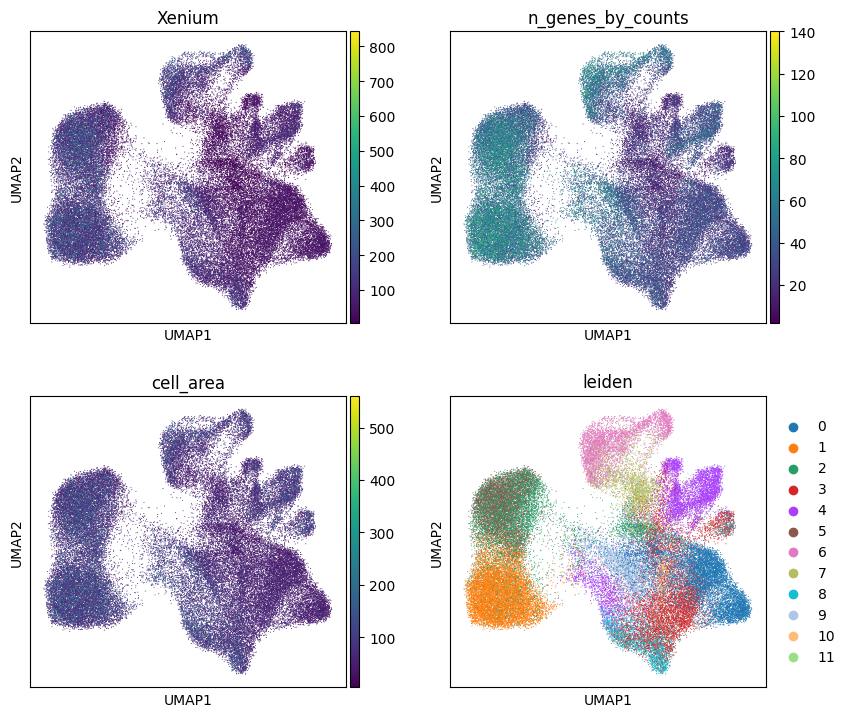

In [16]:
from matplotlib.pyplot import rc_context
with rc_context({"figure.figsize": (4, 4)}): # --> 4x4 inches image
    sc.pl.umap(
            xenium_data, # the plot uses data stored in the umap output .obsm of the ann data file xenium data
            color=[
                "total_counts",
                "n_genes_by_counts",
                "cell_area",
                'leiden'
            ],
            # library_id="spatial",
            # show=False,
            # ax = axs[1],
            ncols=2,
            # spot_size=10,
            title='Xenium',
            # save='metrics_umap.pdf'
    )

## Cell type annotation (as in scRNAseq!)

### 3. Label transfer from a reference

In [17]:
# Subset to same genes again
genes           = list(set(xenium_data.var_names) & set(scRNAseq_data.var_names))
xenium_data     = xenium_data[:, genes]
scRNAseq_data   = scRNAseq_data[:, genes]

This takes a while so we precomputed: 
```python
sc.tl.ingest(xenium_data, scRNAseq_data, obs='annotation_major') #maps new cells (Xenium spatial transcriptomics data) to scRNA-seq reference dataset based on shared transcriptomic profiles
xenium_data.uns['annotation_major_colors'] = scRNAseq_data.uns['annotation_major_colors']
xenium_data.obsm['umap_ingest'] = xenium_data.obsm['X_umap']
sc.tl.umap(xenium_data)
```

In [18]:
scRNAseq_data

View of AnnData object with n_obs × n_vars = 10650 × 411
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'tissue', 'Sample', 'annotation_authors', 'Disease_subtype', 'percent.mt', 'seurat_clusters', 'annotation_CHETAH', 'copykat.pred', 'cell_ontology', 'cell_ontology_id', 'annotation_major', 'annotation_immune', 'annotation_minor'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors', 'pca', 'umap', 'annotation_major_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

[Text(0, 0, 'Malignant'),
 Text(1, 0, 'Plasma'),
 Text(2, 0, 'T'),
 Text(3, 0, 'B'),
 Text(4, 0, 'Fibroblast'),
 Text(5, 0, 'myofibroblast'),
 Text(6, 0, 'Endothelial'),
 Text(7, 0, 'Myeloid'),
 Text(8, 0, 'Unknown')]

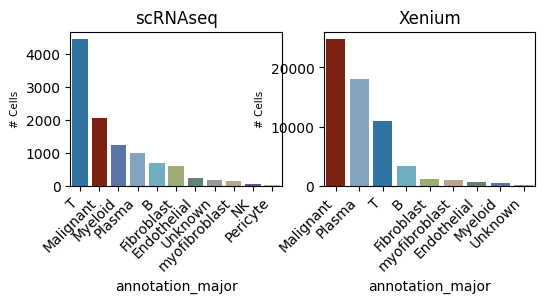

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2))

labels = scRNAseq_data.obs['annotation_major'].value_counts().index
sns.countplot(
    scRNAseq_data.obs, x="annotation_major", #hue='annotation_major',
    # bins=50,
    # hue_order=order,
    palette=major_colors,
    order = labels,
    ax=axs[0],
    # gap=.25
)
axs[0].set_ylabel('# Cells', fontsize=7.5)
axs[0].set_title('scRNAseq')
axs[0].set_xticklabels(labels= labels, rotation=45, ha='right')


labels = xenium_data.obs['annotation_major'].value_counts().index
sns.countplot(
    xenium_data.obs, x="annotation_major", #hue='annotation_major',
    # bins=50,
    # hue_order=order,
    palette=major_colors,
    order = labels,
    ax=axs[1],
    # gap=.25
)
axs[1].set_ylabel('# Cells', fontsize=7.5)
axs[1].set_title('Xenium')
# axs[0].set(ylim=(0, 25_000))
axs[1].set_xticklabels(labels= labels, rotation=45, ha='right')


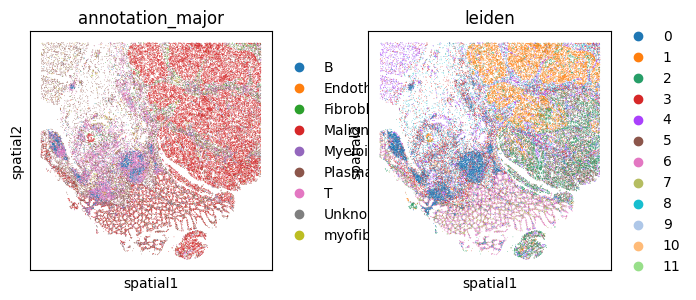

In [21]:
with rc_context({"figure.figsize": (3, 6)}):
    sc.pl.spatial(
            xenium_data,
            color=[
                "annotation_major",
                'leiden'
            ],
            # palette={major_colors, None],
            # library_id="spatial",
            # show=False,
            # ax = axs[1],
            ncols=2,
            spot_size=20,
            # title='Xenium',
            # save='metrics.pdf'
        )

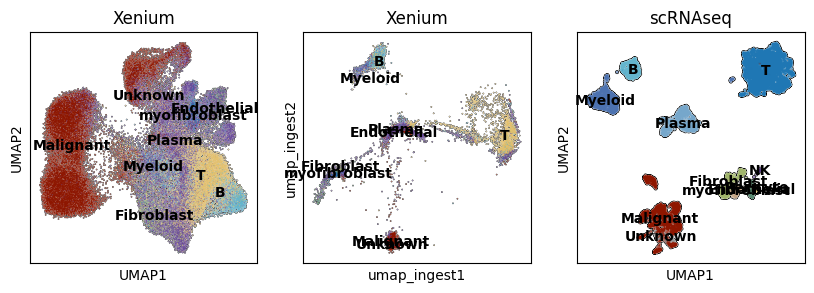

In [22]:
xenium_data.uns['annotation_major_colors'] = scRNAseq_data.uns['annotation_major_colors']

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
sc.pl.umap(
        xenium_data,
        color='annotation_major',
        show=False,
        ax=axs[0],
        add_outline=True,
        legend_loc="on data",
        # palette=major_colors,
        title='Xenium'
    )

sc.pl.embedding(
        xenium_data,
        color='annotation_major',
        show=False,
        ax=axs[1],
        add_outline=True,
        legend_loc="on data",
        basis='umap_ingest',
        # palette=major_colors,
        title='Xenium'
    )

sc.pl.umap(
        scRNAseq_data,
        color='annotation_major',
        show=False,
        ax = axs[2],
        legend_loc="on data",
        add_outline=True,
        palette=major_colors,
        title='scRNAseq'
    )
plt.show()

In [23]:
 # Drop rare cell types! (CAUTION!)
min_cells_per_celltype = 50
vals = xenium_data.obs.annotation_major.value_counts().values > min_cells_per_celltype
labels = xenium_data.obs.annotation_major.value_counts().index
types = [i for indx,i in enumerate(labels) if vals[indx] == True]
xenium_data = xenium_data[xenium_data.obs.annotation_major.isin(types)]

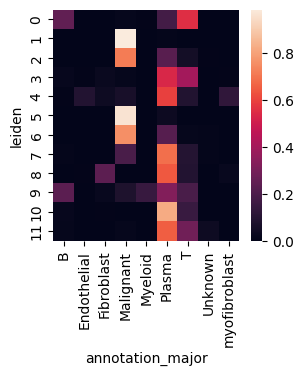

In [24]:
with rc_context({"figure.figsize": (3, 3)}):
    xenium_data.obs['annotation_major'] = xenium_data.obs['annotation_major'].cat.remove_unused_categories()
    cmtx = sc.metrics.confusion_matrix("leiden", "annotation_major", xenium_data.obs)
    sns.heatmap(cmtx)

### 4. Exploring marker expression

In [25]:
xenium_data.obs['annotation_major'] = xenium_data.obs['annotation_major'].cat.remove_unused_categories()

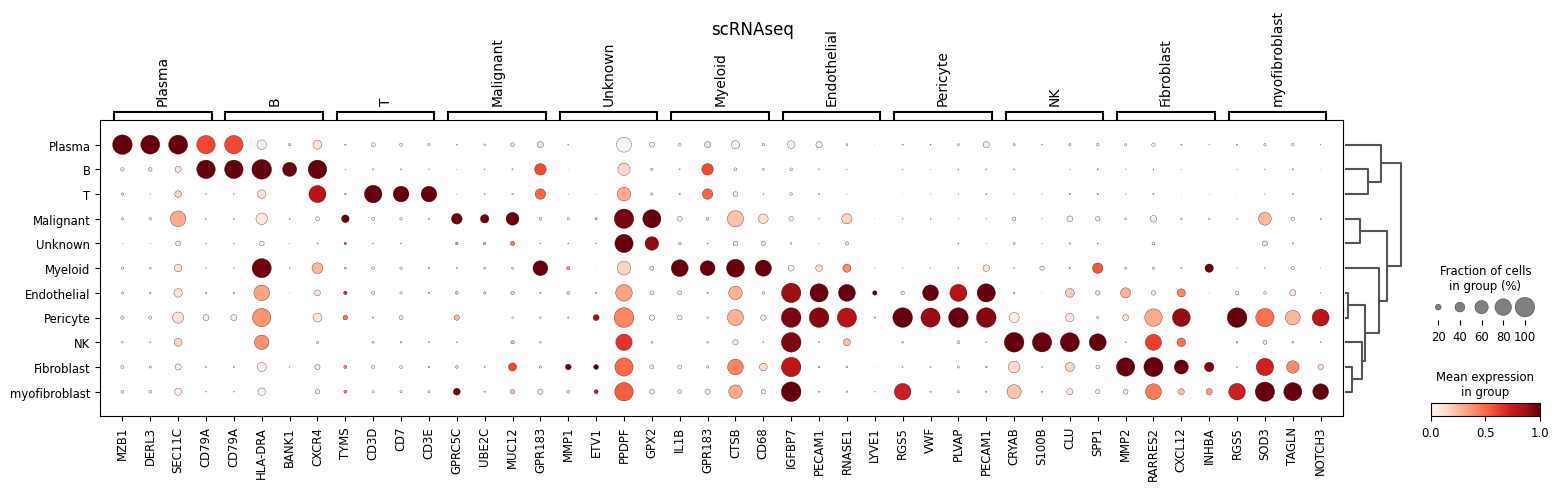

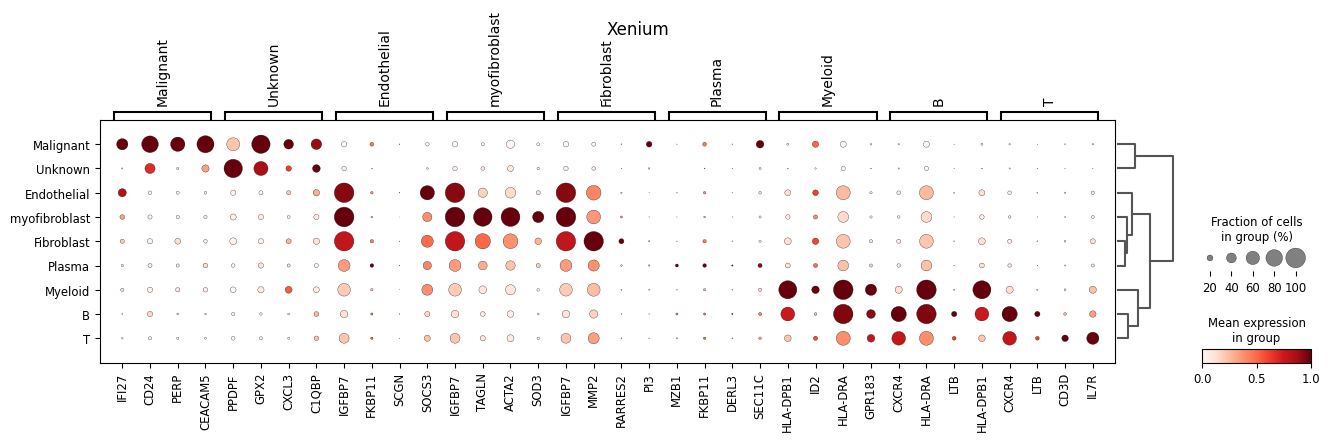

In [26]:
with rc_context({"figure.figsize": (4, 2)}):
    sc.tl.rank_genes_groups(scRNAseq_data, 'annotation_major', method='logreg',max_iter=100)
    sc.pl.rank_genes_groups_dotplot(scRNAseq_data, n_genes=4, standard_scale='var', title='scRNAseq')
    sc.tl.rank_genes_groups(xenium_data, 'annotation_major', method='logreg',max_iter=100)
    sc.pl.rank_genes_groups_dotplot(xenium_data, n_genes=4, standard_scale='var', title='Xenium')

## Bring in the Space!

[Let's look at the data!](https://xenium.10xgenomics.com/?image=s3%2F10x.files%2Fxenium%2Fpreview%2Fhbreast%2Fexperiment.xenium&zoom=0.0217&target=19259.42_12511.18&z=17&off=&layers=cell~image&mi_v=true&nav=true&axes=false&feature=icon&feature_psc=6&feature_ps=circles&ii_n=H%26E%20Image&ii_p=s3%2F10x.files%2Fxenium%2Fpreview%2FXenium_FFPE_Human_Breast_Cancer_Rep1%2FXenium_FFPE_Human_Breast_Cancer_Rep1_he_image_registered.ome.tif&ii_t=AAAAAAAA8D8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADwPwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPA%2F&ii_v=true&feature_off=313_541&bin=10&d_c=Viridis&d_o=0.8&cell_bt=cell&cell_c=groups&cell_g=0&cell_o=0.5&ct_c=Viridis&ct_o=0.8&cell_v=filled)

### 5. Neighborhood graphs

In [27]:
sq.gr.spatial_neighbors(xenium_data, coord_type="generic", n_neighs=15)

In [28]:
xenium_data

AnnData object with n_obs × n_vars = 60290 × 411
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'annotation_major'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'annotation_major_nhood_enrichment', 'annotation_major_sizes', 'dendrogram_annotation_major', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'rep', 'spatial', 'umap_ingest'
    varm: 'PCs'
    layers: 'counts'
  

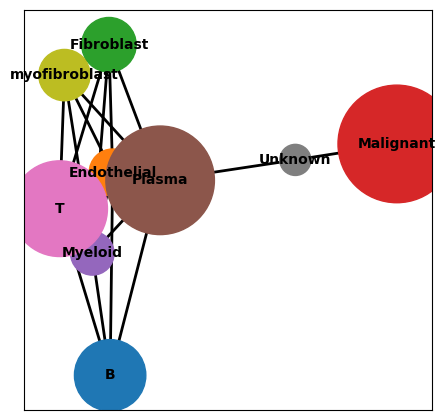

In [29]:
sc.tl.paga(xenium_data, groups='annotation_major', neighbors_key="spatial_neighbors", copy=False)
sc.pl.paga(xenium_data, max_edge_width=2, node_size_scale=10, threshold= .8)

```python
sq.gr.nhood_enrichment(xenium_data, cluster_key="annotation_major")
```

This added 

    - :attr:`anndata.AnnData.uns` ``['{cluster_key}_nhood_enrichment']['zscore']`` - the enrichment z-score.
    - :attr:`anndata.AnnData.uns` ``['{cluster_key}_nhood_enrichment']['count']`` - the enrichment count.

In [30]:
xenium_data

AnnData object with n_obs × n_vars = 60290 × 411
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'annotation_major'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'annotation_major_nhood_enrichment', 'annotation_major_sizes', 'dendrogram_annotation_major', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'spatial_neighbors', 'umap', 'annotation_major_colors'
    obsm: 'X_pca', 'X_umap', 'rep', 'spatial', 'umap_ingest'
    varm: 'P

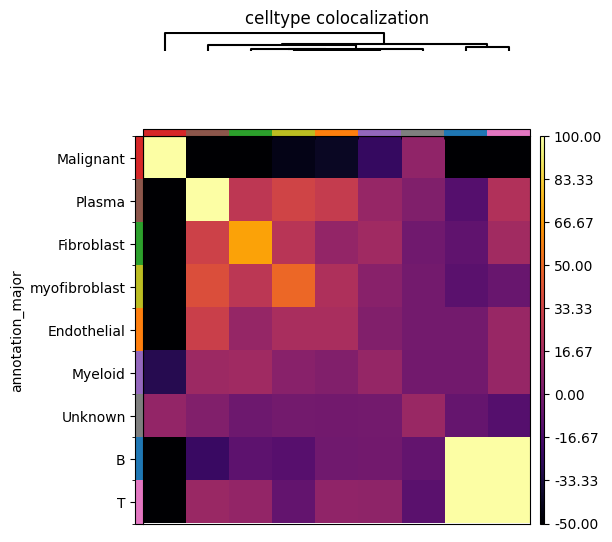

In [31]:
sq.pl.nhood_enrichment(
    xenium_data,
    cluster_key="annotation_major",
    method="average",
    cmap="inferno",
    vmin=-50,
    vmax=100,
    figsize=(5, 5),
    title='celltype colocalization'
)

### 6. Spatially informative genes

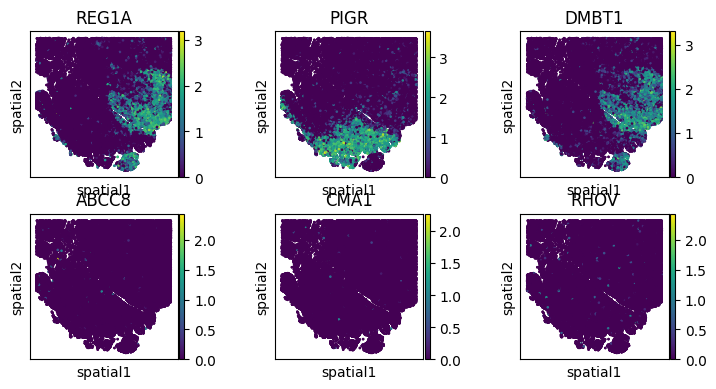

In [32]:
with rc_context({"figure.figsize": (2, 2)}):
    sq.gr.spatial_autocorr(xenium_data, mode="moran")
    top_genes = xenium_data.uns["moranI"].head().index[:3]
    low_genes = xenium_data.uns["moranI"].tail().index[:3]
    sq.pl.spatial_scatter(
        xenium_data, shape=None, color=top_genes.append(low_genes), size=3, ncols=3, legend_loc=None,
    )

### 7. Niche detection


Idea: locate spatial niches by clustering cells based on proportion of surrounding celltypes

1. encode cell type with one-hot encoding (celltype of cell: 1, other celltypes:0)
2. create weighted sum of celltypes in spatial proximity & normalise
3. compute K-nearest neighbour graph based on this representation -> cells with similar proportion of surrounding celltypes are connected
4. compute leiden clustering on KNN graph to identify clusters (= niches)



In [35]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

xenium_data2 = xenium_data.copy()
xenium_data2.X = xenium_data2.X.toarray()
sc.pp.subsample(xenium_data2, 0.1)

celltype_one = ohe.fit_transform(xenium_data2.obs[['annotation_major']])
celltype_dist = xenium_data2.obsp['spatial_connectivities'] @ celltype_one
celltype_dist /= celltype_dist.sum(axis=1)
xenium_data2.obsm['celltype_dist'] = celltype_dist.tocsc()
# sc.pp.subsample(xenium_data2, 0.1)
a = knn_adjacency_matrix(xenium_data2.obsm['celltype_dist'].toarray(), k = 100)
xenium_data2.obsp['niche_connectivities_minor'] = a.toarray()

In [36]:
sc.tl.leiden(xenium_data2, adjacency=xenium_data2.obsp['niche_connectivities_minor'], key_added='niche', resolution=0.2)

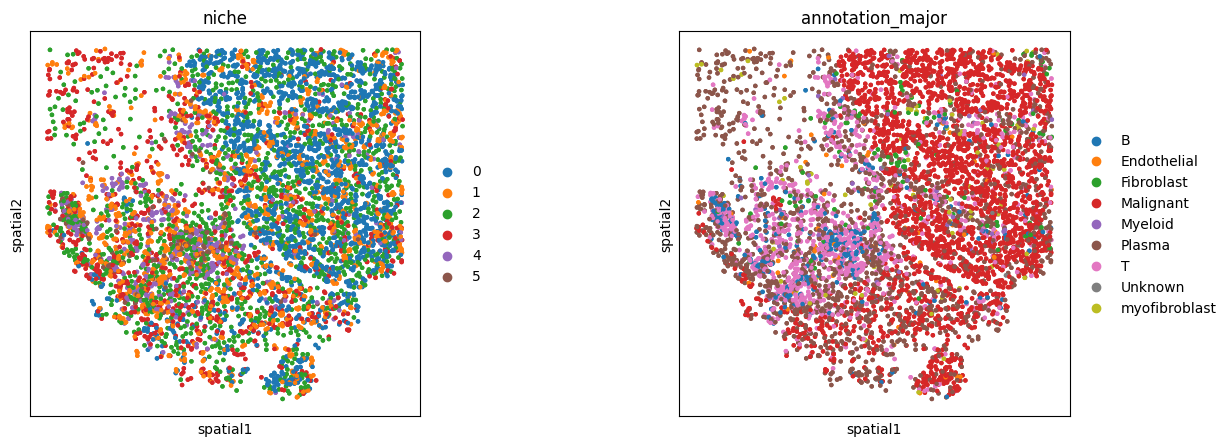

In [37]:
sq.pl.spatial_scatter(
    xenium_data2,
    library_id="spatial",
    shape=None,
    color=[
        "niche",
        "annotation_major"
    ],
    wspace=0.4,
)

<Axes: xlabel='niche', ylabel='annotation_major'>

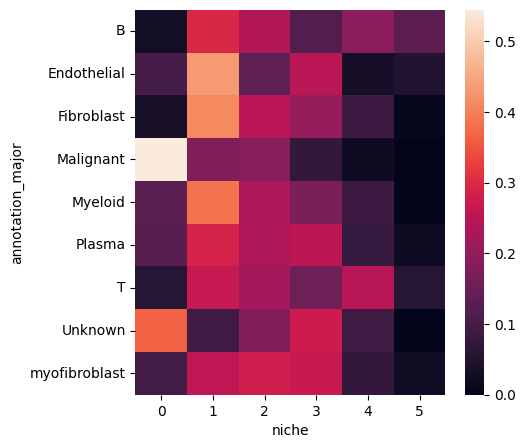

In [38]:
cmtx = sc.metrics.confusion_matrix("annotation_major", "niche", xenium_data2.obs)
sns.heatmap(cmtx)

## Extra links

* [`SpatialData`, a framework for wrangling one and multiple spatial omics datasets across samples and technologies](https://spatialdata.scverse.org/en/latest/)
* [Celltype annotation for visium using cell2location](https://cell2location.readthedocs.io/en/latest/)
* [Linear alignment of Xenium and Visium (10X general)](https://www.10xgenomics.com/support/software/xenium-explorer/latest/tutorials/xe-image-alignment)
* [None-linear alignment of Xenium and Visium (STalign)](https://jef.works/blog/2023/12/27/alignment-of-spatial-transcriptomics-data-using-STalign/)
* [Xenium Cell Segmentation; best practices](https://www.biorxiv.org/content/10.1101/2023.02.13.528102v1)